In [1]:
from dolfinx import fem, mesh
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 
from ufl import (TrialFunction, TestFunction, dx, ds, grad, inner)

import timeit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def problem_setup(N: int, 
                  points: list[float, float], 
                  fluid: str, 
                  freq: float, 
                  pressure: float):
    """
    Performs problem configuration w.r.t. given parameters
    """
    
    # Mesh and function space definition
    domain = mesh.create_interval(MPI.COMM_WORLD, N, points)
    V = fem.FunctionSpace(domain, ("CG", 1))

    u = TrialFunction(V)
    v = TestFunction(V)
    
    # Construction of bilinear form and linear functional
    ro, c = fluids.loc[fluid, ['Density', 'Speed of sound']]
    omega = freq * 2 * np.pi
    
    aa = ScalarType(ro * c**2) * inner(grad(u), grad(v)) * dx
    mm = ScalarType(ro) * inner(u, v) * dx

    Left = aa - omega**2 * mm
    Right = pressure * v * ds
    
    # Setting Dirichlet boundary condition
    def LeftBoundary(x):
        return np.isclose(x[0], 0)
    
    boundary_dofs = fem.locate_dofs_geometrical(V, LeftBoundary)
    bc = fem.dirichletbc(fem.Constant(domain, ScalarType(0.0)), boundary_dofs, V)
    
    return {
        'Params': (fluid, points, c, ro, omega, pressure),
        'FunctionSpace': (domain, V, u, v),
        'Problem': (Left, Right, bc)
    }

#### Available fluids

In [3]:
fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
fluids

,Density,Speed of sound,Viscosity
Fluid,,,
Water,1000,1500,0.000894
Fuel oil,890,1360,2.022000


In [4]:
config = problem_setup(N=20, 
                       points=[0.0, 10.0],
                       fluid='Water',
                       freq=160,
                       pressure=1.0)

fluid, points, speed, density, omega, pressure = config['Params']
domain, V, u, v = config['FunctionSpace']
Left, Right, bc = config['Problem']

In [5]:
problem = fem.petsc.LinearProblem(Left, Right, bcs=[bc])
uh = problem.solve()

#### Exact solution for the given problem:

$$
\begin{align}
{\large u = \frac{ p \cdot sin(\frac{\omega}{c} \cdot x)) }
{ \rho \cdot c \cdot \omega \cdot cos(\frac{\omega}{c} \cdot b))} }
\end{align}
$$

In [6]:
def u_exact(x):
    return (pressure * np.sin(omega * x[0] / speed)) / \
           (density * speed * omega * np.cos(omega * points[1] / speed))

u_ex = fem.Function(V)
u_ex.interpolate(u_exact)

## Results

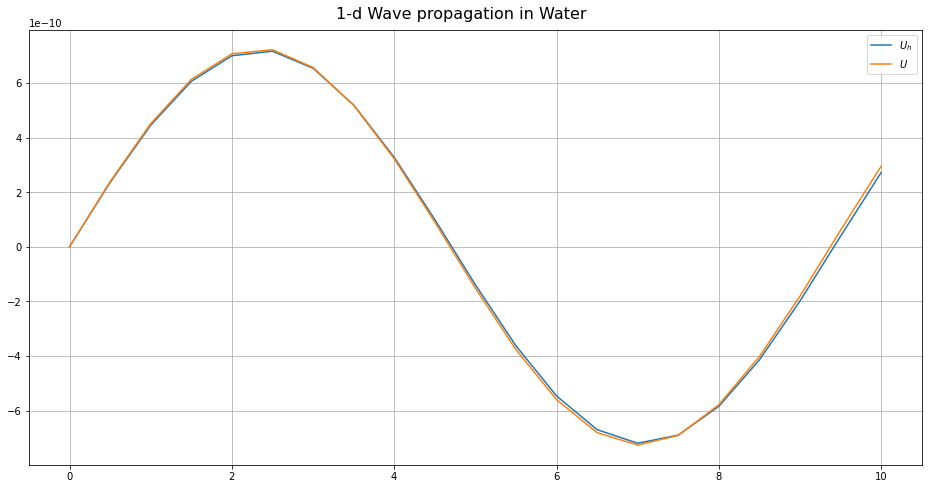

In [7]:
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle(f'1-d Wave propagation in {fluid}', y=0.92, fontsize=16)

xs1 = np.linspace(points[0], points[1], uh.vector.array.size)
xs2 = np.linspace(points[0], points[1], u_ex.vector.array.size)

ax.plot(xs1, uh.vector.array, label=r'$ U_h $')
ax.plot(xs2, u_ex.vector.array, label=r'$ U $')

ax.legend()
ax.grid()

In [8]:
def L2_norm(fun):
    comm = uh.function_space.mesh.comm
    error = fem.form(fun**2 * dx)
    norm = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))
    
    if comm.rank == 0:
        return norm

In [9]:
def L2_error(uh, u_ex):
    comm = uh.function_space.mesh.comm
    error = fem.form((uh - u_ex)**2 * dx)
    E = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))
    
    if comm.rank == 0:
        return E

In [10]:
print(f"L2 Error: {L2_error(uh, u_ex):.2e}")

L2 Error: 3.28e-11


## Convergence

In [11]:
def calc_convergence(rounds: int = 5):
    """
    Convergence calculation
    """
    
    results = list()
    for i in range(rounds):
        config = problem_setup(N=10 * 2**i, 
                           points=[0.0, 10.0],
                           fluid='Water',
                           freq=160,
                           pressure=1.0)

        fluid, points, speed, density, omega, pressure = config['Params']
        domain, V, u, v = config['FunctionSpace']
        Left, Right, bc = config['Problem']
        
        problem = fem.petsc.LinearProblem(Left, Right, bcs=[bc])
        
        start = timeit.default_timer()
        uh = problem.solve()
        stop = timeit.default_timer()
        
        u_ex = fem.Function(V)
        u_ex.interpolate(u_exact)
        
        norm_l2_uh = L2_norm(uh)
        error = L2_error(uh, u_ex)
        
        results.append([10 * 2**i, norm_l2_uh, error, np.nan, stop - start])
                  
        if len(results) > 2:
            results[-1][3] = np.log2((results[-3][2] - results[-2][2])/(results[-2][2] - results[-1][2]))
        
    return results

In [12]:
cdata = calc_convergence(14)
cdf = pd.DataFrame(cdata, columns=['N', '||u_h||', 'error', 'k', 'time']).set_index('N')
cdf

,||u_h||,error,k,time
N,,,,
10,1.492846e-09,1.179467e-10,NaN,0.000482
20,1.552151e-09,3.284039e-11,NaN,0.000347
40,1.570885e-09,8.460551e-12,1.803577,0.000406
80,1.575851e-09,2.131528e-12,1.945634,0.000349
160,1.577110e-09,5.339185e-13,1.986068,0.000389
320,1.577426e-09,1.335446e-13,1.996495,0.000631
640,1.577506e-09,3.339021e-14,1.999122,0.000539
1280,1.577525e-09,8.347805e-15,1.999781,0.000827
2560,1.577530e-09,2.087136e-15,1.999984,0.001583
